# IMPORT & SETUP

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, \
    f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler


In [8]:
file_path = 'dataset/train.csv'
data = pd.read_csv(file_path)

features_used = ['Inherited from father', 'Maternal gene', 'Paternal gene', 'Genes in mother\'s side', 'Symptom 1',
                 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']
targets = ['Genetic Disorder', 'Disorder Subclass']

dataset = data.loc[:, features_used + targets].dropna(subset=['Genetic Disorder', 'Disorder Subclass'], how='all')
# Fill missing values in 'Genetic Disorder' based on 'Disorder Subclass'
subclass_to_disorder = {
    'Leber\'s hereditary optic neuropathy': 'Mitochondrial genetic inheritance disorders',
    'Leigh syndrome': 'Mitochondrial genetic inheritance disorders',
    'Mitochondrial myopathy': 'Mitochondrial genetic inheritance disorders',
    'Alzheimer\'s': 'Multifactorial genetic inheritance disorders',
    'Cancer': 'Multifactorial genetic inheritance disorders',
    'Diabetes': 'Multifactorial genetic inheritance disorders',
    'Cystic fibrosis': 'Single-gene inheritance diseases',
    'Hemochromatosis': 'Single-gene inheritance diseases',
    'Tay-Sachs': 'Single-gene inheritance diseases',
}

dataset['Genetic Disorder'] = dataset.apply(
    lambda row: subclass_to_disorder[row['Disorder Subclass']]
    if pd.isna(row['Genetic Disorder']) else row['Genetic Disorder'],
    axis=1
)
dataset = dataset.drop(['Disorder Subclass'], axis=1)
dataset = dataset.dropna(subset=['Genetic Disorder'], how='all')

# CATEGORIAL BINARY
dataset["Genes in mother's side"] = dataset["Genes in mother's side"].replace({'Yes': 1.0, 'No': -1.0})
dataset['Inherited from father'] = dataset['Inherited from father'].replace({'No': -1.0, 'Yes': 1.0})
dataset['Maternal gene'] = dataset['Maternal gene'].replace({'No': -1.0, 'Yes': 1.0})
dataset["Paternal gene"] = dataset["Paternal gene"].replace({'Yes': 1.0, 'No': -1.0})

dataset[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']] = dataset[['Symptom 1', 'Symptom 2', 'Symptom 3', 'Symptom 4', 'Symptom 5']].fillna(-1)
dataset = dataset.dropna(subset=['Symptom 4', 'Symptom 5'])
# -------------------------------------------------------%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%--------------------------------#
genetic_disorder_mapping = {
    'Mitochondrial genetic inheritance disorders': 1,
    'Multifactorial genetic inheritance disorders': 0,
    'Single-gene inheritance diseases': 2,
}
dataset['Genetic Disorder'] = dataset['Genetic Disorder'].map(genetic_disorder_mapping)

# disorder_subclass_mapping = {
#     "Leber's hereditary optic neuropathy": 0,
#     'Cystic fibrosis': 1,
#     'Diabetes': 2,
#     'Leigh syndrome': 3,
#     'Tay-Sachs': 4,
#     'Mitochondrial myopathy': 5,
#     'Hemochromatosis': 6,
#     "Alzheimer's": 7,
#     'Cancer': 8,
# }
# dataset['Disorder Subclass'] = dataset['Disorder Subclass'].map(disorder_subclass_mapping)
heat_data = dataset.dropna()

In [9]:
robust_scaler = RobustScaler()

X_train, X_test, Y_train, Y_test = train_test_split(
    robust_scaler.fit_transform(heat_data.loc[:, heat_data.columns != 'Genetic Disorder']),
    heat_data.loc[:, 'Genetic Disorder'],
    test_size=0.1, random_state=43)

In [31]:
from imblearn.under_sampling import NearMiss

undersample = NearMiss()
X_train, Y_train = undersample.fit_resample(X_train, Y_train)

In [34]:
from imblearn.over_sampling import BorderlineSMOTE

sm = BorderlineSMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(X_train, Y_train)
# print(f'''shape of X before SMOTE: {heat_data.shape} 
# shape of X after SMOTE: {X_sm.shape}''')
# print('balanced class (%):')
# y_sm.value_counts(normalize=True) * 100

In [10]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
lp_models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)
lp_models

100%|██████████| 29/29 [00:34<00:00,  1.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32
[LightGBM] [Info] Number of data points in the train set: 16914, number of used features: 9
[LightGBM] [Info] Start training from score -2.260558
[LightGBM] [Info] Start training from score -0.671508
[LightGBM] [Info] Start training from score -0.955109


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.62,0.55,None,0.61,0.15
LabelPropagation,0.60,0.54,None,0.60,6.21
ExtraTreesClassifier,0.60,0.53,None,0.60,0.67
DecisionTreeClassifier,0.60,0.53,None,0.60,0.03
LabelSpreading,0.60,0.53,None,0.60,12.02
ExtraTreeClassifier,0.60,0.53,None,0.59,0.02
XGBClassifier,0.62,0.53,None,0.61,0.19
RandomForestClassifier,0.61,0.53,None,0.60,0.64
KNeighborsClassifier,0.58,0.52,None,0.58,0.09


In [11]:
param_distributions = {
    "max_features": [1, 2, 3, 5, None],
    "max_leaf_nodes": [10, 100, 1000, None],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
    "min_samples_split": [2, 5, 10, 20, 50, 100],
    "n_estimators": [200, 300, 400, 800, 1000, 1400],
    "max_depth": [1, 2, 3, 5, 10, 20, 50, 100, None],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

## Importing Random Forest Classifier from the sklearn.ensemble

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, scoring='f1_macro',
                               n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=12)

rf_random.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, criterion=gini, max_depth=50, max_features=1, max_leaf_nodes=None, min_samples_leaf=100, min_samples_split=50, n_estimators=400; total time=   2.0s
[CV] END bootstrap=False, criterion=gini, max_depth=None, max_features=1, max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; total time=   5.0s
[CV] END bootstrap=False, criterion=gini, max_depth=5, max_features=None, max_leaf_nodes=100, min_samples_leaf=20, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=100, n_estimators=800; total time=   2.2s
[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_features=2, max_leaf_nodes=10, min_samples_leaf=100, min_samples_split=100, n_estimators=800; total time=   1.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=1, max_fe

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=12,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 5, 10, 20, 50,
                                                      100, None],
                                        'max_features': [1, 2, 3, 5, None],
                                        'max_leaf_nodes': [10, 100, 1000, None],
                                        'min_samples_leaf': [1, 2, 5, 10, 20,
                                                             50, 100],
                                        'min_samples_split': [2, 5, 10, 20, 50,
                                                              100],
                                        'n_estimators': [200, 300, 400, 800,
                                                         1000, 1400]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [12]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_leaf_nodes': None,
 'max_features': 5,
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': True}

In [13]:
y_pred = rf_random.predict(X_test)

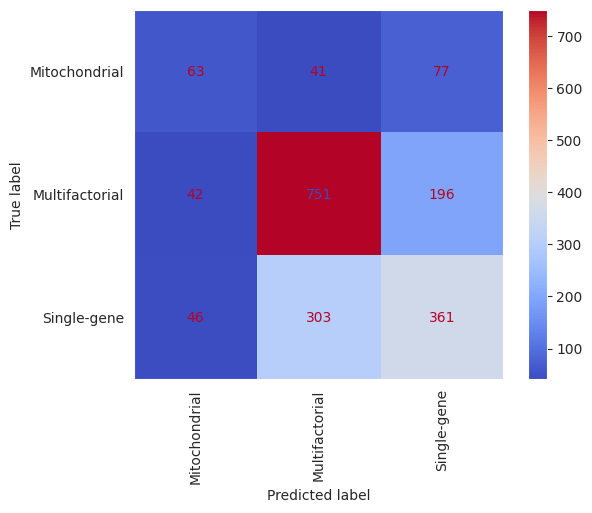

In [14]:
disorder_labels = [
    'Mitochondrial',
    'Multifactorial',
    'Single-gene'
]

# inv_dict = {v: k for k, v in genetic_disorder_mapping_2.items()}

cm = confusion_matrix(Y_test, y_pred,
                      labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disorder_labels)
disp.plot(cmap='coolwarm', ax=None)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.grid(False)
# plt.title('Confusion Matrix RF for Genetic Disorder', fontsize=20)
plt.savefig('confusion_matrix.png', transparent=True, bbox_inches='tight')
plt.show()


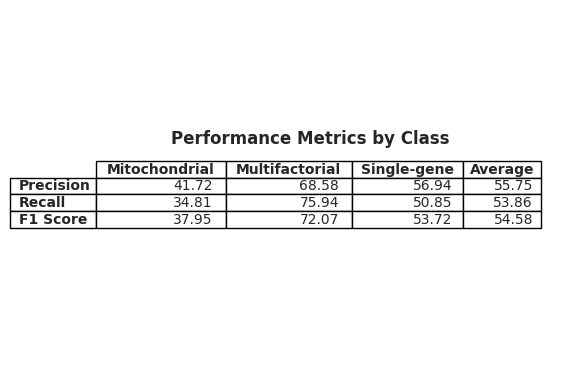

In [15]:
from matplotlib.font_manager import FontProperties
from sklearn.metrics import precision_recall_fscore_support as score

scores = score(Y_test, y_pred) * np.array([100, ])
precision, recall, fscore, support = scores

# Calculate row averages
precision_avg = np.mean(precision)
recall_avg = np.mean(recall)
fscore_avg = np.mean(fscore)

# Create a figure and axis
fig, ax = plt.subplots()

table_data_transposed = [[round(i, 2) for i in list(precision) + [precision_avg, ]],
                         [round(i, 2) for i in list(recall) + [recall_avg, ]],
                         [round(i, 2) for i in list(fscore) + [fscore_avg, ]],
                         ]

# Create the table with rows and columns inverted
table = plt.table(cellText=table_data_transposed,
                  rowLabels=['Precision', 'Recall', 'F1 Score'],
                  colLabels=['Mitochondrial', 'Multifactorial', 'Single-gene', 'Average'],
                  loc='center')

# Style the headers to make them bold
# Style the headers to make them bold
for (row, col), cell in table.get_celld().items():
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'))

# Style the table
table.auto_set_column_width(col=list(range(len(table_data_transposed[0]))))
# table.auto_set_row_height(row=list(range(len(table_data_transposed))))

table.set_fontsize(10)
# table.scale(1, 1)
# table.fit_text = True

# Hide the axes
ax.axis('off')
# ax.set_title('Label Scores', fontsize=20)
# plt.title('Label Scores', fontsize=20)

plt.suptitle('Performance Metrics by Class', fontsize=12, weight='bold', y=0.63)
plt.savefig('table.png', transparent=True, bbox_inches='tight')
# Display the plot
plt.show()
